# Time Series

 Se dice que una serie es estacionaria cuando sus propiedades estadísticas no varían con el paso del tiempo. En una serie estacionaria la media, la varianza y la autocorrelación permanecen constantes a lo largo del tiempo. La estacionalidad puede ser definida en términos matemáticos precisos, aunque para nuestro propósito nos referiremos a una serie temporal que no muestra tendencias persistentes y que no muestra procesos cíclicos.

In [1]:
import psycopg2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from datetime import datetime
from numpy import cumsum, log, polyfit, sqrt, std, subtract
from sqlalchemy import create_engine

from local_settings import db_user, db_password, db_host, db_port, db_name

warnings.filterwarnings("ignore")

def datetime_to_timestamp(date):
    return datetime.timestamp(date)

def timestamp_to_datetime(timestamp):
    return datetime.fromtimestamp(timestamp)

def normalize_date(date):
    return date.strftime("%Y-%m-%d %H:%M:%S")

def psql_today(date):
    return date.strftime("%Y-%m-%d")

def to_seconds(data):
    return data.total_seconds()/3600


endpoint = f"postgres://{db_user}:{db_password}@{db_host}/{db_name}"
connection = create_engine(endpoint)
#connection = psycopg2.connect(user=db_user, password=db_password, host=db_host, port=db_port, database=db_name)

_TABLE_NAME = "incident"
_CUSTOMER = "MyCustomer"
_BACK_TIME = 90
_VARIABLES = "id, discovered_date, create_date"
_NOW = psql_today(datetime.now())

sql_query = f"select {_VARIABLES} from {_TABLE_NAME} where org_name='{_CUSTOMER}' and discovered_date >= '{_NOW}'::date - interval '{_BACK_TIME} day'"
df = pd.read_sql_query(sql_query, connection, index_col="discovered_date")

print("Missing values: ", df.isna().sum())
_BATCH = "D"
serie = df.resample(_BATCH, base=1)["id"].agg(["count"])
#serie.fillna(methond="bfill")
serie.to_csv(_CUSTOMER.lower() + "_incident_data.csv", index=True)
serie

Missing values:  id             0
create_date    0
dtype: int64


,count
discovered_date,
2020-08-25 00:00:00+00:00,6
2020-08-26 00:00:00+00:00,7
2020-08-27 00:00:00+00:00,21
2020-08-28 00:00:00+00:00,8
2020-08-29 00:00:00+00:00,0
...,...
2020-11-19 00:00:00+00:00,23
2020-11-20 00:00:00+00:00,9
2020-11-21 00:00:00+00:00,11


<function matplotlib.pyplot.show(*args, **kw)>

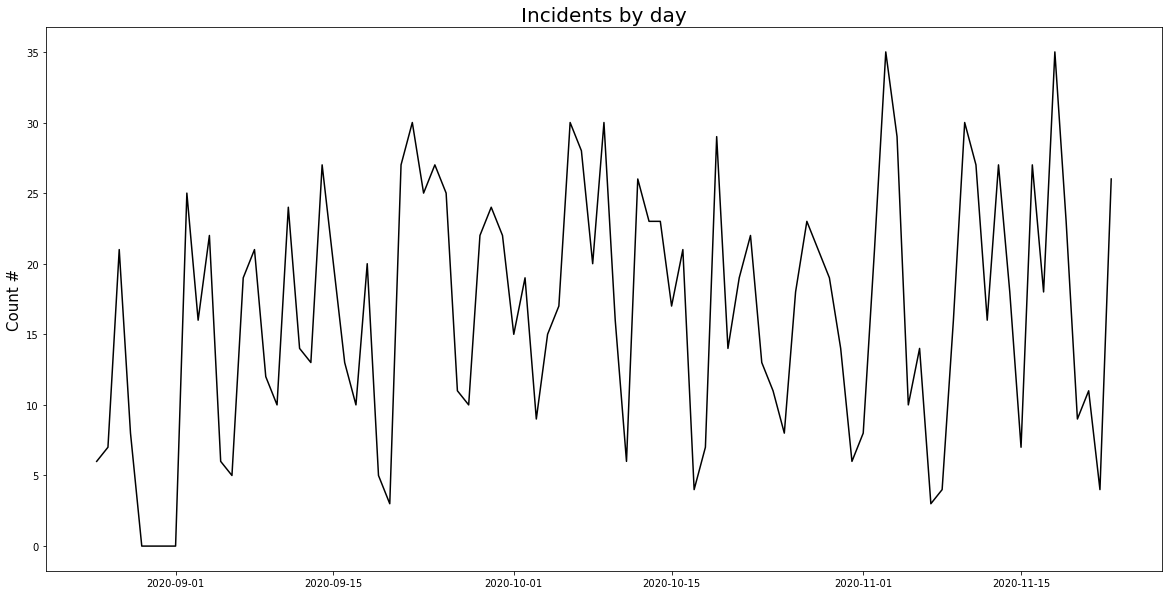

In [2]:
plt.figure(figsize=(20, 10))
plt.plot(serie, "k")
plt.title("Incidents by day", size=20)
plt.ylabel("Count #", size=15)
plt.show

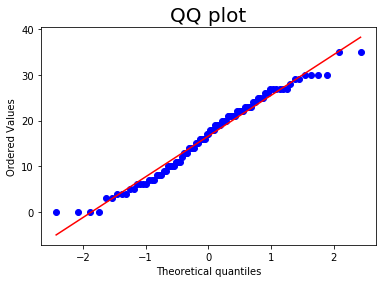

In [3]:
# línea roja indica distribución normal
from scipy.stats import probplot

probplot(serie[serie.columns[0]], plot=plt)
plt.title("QQ plot", size=20)
plt.show()

## Test estadísticos

A pesar de que los test estadísticos pueden hacer suposiciones sólidas sobre los datos, solo se pueden usar para informar el grado en que una hipótesis nula puede rechazarse. El resultado del test debe interpretarse para que un problema dado sea significativo aunque siempre pueden proporcionar una verificación rápida y una evidencia confirmatoria de que la serie temporal es (o no) estacionaria.

### Estacionalidad

Para verificar la estacionalidad (que no estacionariedad) de una serie temporal podemos tomar dos enfoques. Primero debemos descomponer la serie en tres efectos

- Efecto de tendencia: presencia de un patrón consistente en nuestra serie. 
- Efecto estacional: efectos cíclicos debidos a la estacionalidad.
- Efecto residual: error de predicción o diferencia entre datos reales y los datos observados.

Los enfoques a seguir son los siguientes

- Enfoque aditivo. Para cualquier tiempo, el valor observado es el resultado de tendencia + estacional + residual. Este enfoque resulta apropiado cuando la serie sigue una tendencia constante/lineal.

- Enfoque multiplicativo. El valor observado es resultado de la multiplicación de los tres efectos. Apropiado cuand la tendencia es no lineal.

<function matplotlib.pyplot.show(*args, **kw)>

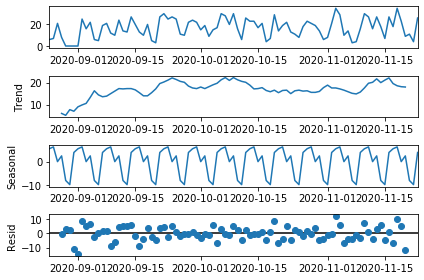

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Enfoque aditivo
s_additive = seasonal_decompose(serie, model="additive")
s_additive.plot()
plt.show

In [5]:
# Enfoque multiplicativo
try:
#if serie[serie==0].count() == 0:
    multiplicative = seasonal_decompose(serie, model="multiplicative")
    multiplicative.plot()
    plt.show
except ValueError:
    print("Multiplicative seasonality is not appropriate for zero and negative values")

Multiplicative seasonality is not appropriate for zero and negative values


### ACF & PACF

La función de Autocorrelación (ACF) es una herramienta de análisis estadístico que nos permite encontrar el nivel de autocorrelación de los datos y en qué retrasos $k$ se produce. Es decir, nos ayuda a saber qué dependencia tienen los datos de un período determinado con los mismos de hace $k$ períodos anteriores.

La utilidad de la ACF consiste en medir la inercia o tendencia de una serie temporal, es decir, ver qué grado de dependencia muestran los datos de ahora con los datos de hace $k$ períodos anteriores.

Esta función varía dentro del rango $(−1, 1)$, donde 1 indica una correlación perfecta (la señal se superpone perfectamente tras un desplazamiento temporal de $k$) y −1 indica una anticorrelación perfecta.

Por otro lado, la función de Autocorrelación Parcial (PACF) intenta eliminar la dependencia indirecta de los retrasos anteriores.

El primer valor de ACF y PACF debe coincidir.

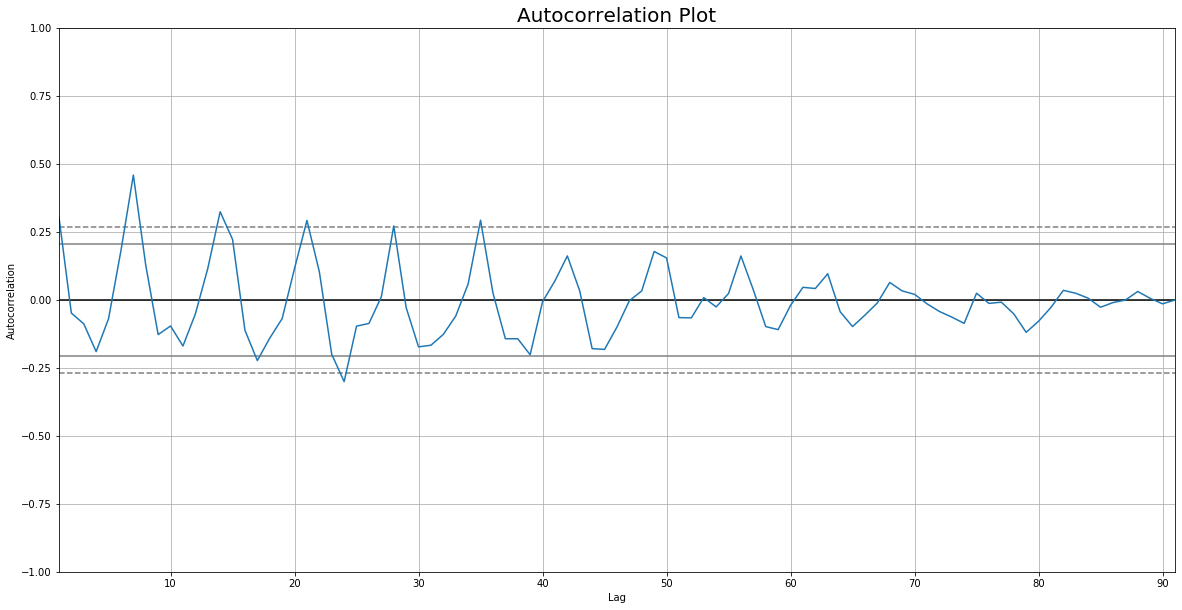

In [6]:
from pandas.plotting import autocorrelation_plot

plt.figure(figsize=(20, 10))
autocorrelation_plot(serie)
plt.title("Autocorrelation Plot", size= 20)
plt.show()

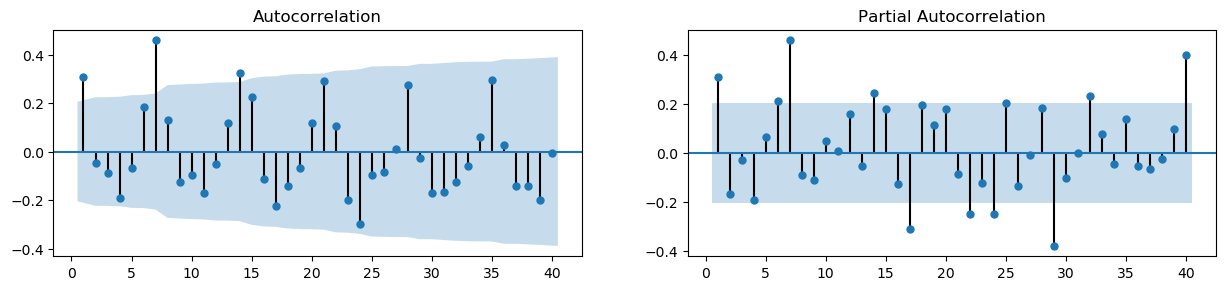

In [7]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# dentro del área azul indica que no hay autocorrelación para los retrasos
fig, ax = plt.subplots(1, 2, figsize=(15, 3), dpi=100)
plot_acf(serie, lags=40, zero=False, use_vlines=True, ax=ax[0])
plot_pacf(serie, lags=40, zero=False, use_vlines=True, ax=ax[1], method=("ols"))
fig.show()

In [8]:
from statsmodels.tsa.stattools import acf, pacf

acf_20 = acf(serie, nlags=20)
pacf_20 = pacf(serie, nlags=20)
acf_20, pacf_20

(array([ 1.        ,  0.30555872, -0.04808554, -0.08763465, -0.18990757,
        -0.06883956,  0.18179867,  0.45957901,  0.12797264, -0.12718407,
        -0.09563663, -0.16926466, -0.0513967 ,  0.11560147,  0.32482571,
         0.22284836, -0.11139802, -0.22279039, -0.14021946, -0.06847302,
         0.11622734]),
 array([ 1.        ,  0.30895382, -0.15987947, -0.02678407, -0.18808757,
         0.04752203,  0.19404612,  0.43034898, -0.18409371, -0.11429127,
         0.01342094, -0.01773354,  0.02769127, -0.04373993,  0.21487564,
         0.17861796, -0.1808085 , -0.29399117,  0.13903965,  0.07017815,
         0.08902422]))

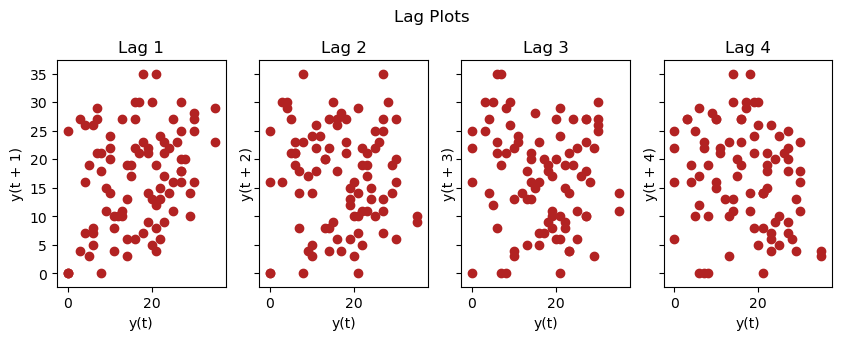

In [9]:
from pandas.plotting import lag_plot

fig, axes = plt.subplots(1, 4, figsize=(10, 3), sharex=True, sharey=True, dpi=100)
for i, ax in enumerate(axes.flatten()[:4]):
    lag_plot(serie, lag=i+1, ax=ax, c="firebrick")
    ax.set_title("Lag " + str(i+1))

# si no hay patrón en la distribución de puntos, la serie se asemeja a un "ruido blanco"
fig.suptitle("Lag Plots", y=1.05)    
plt.show()

### Augmented Dickey-Fuller (ADF)

El test estadístico de referencia utilizado para conocer si una serie es o no estacionaria es la prueba de Dickey Fuller aumentada (ADF). La prueba es un tipo de test estadístico llamado "prueba de raíz unitaria" (unit root test). La idea detrás de una prueba de raíz unitaria es que determina la fuerza con la que una serie de tiempo está definida por su tendencia. El test utiliza un modelo autorregresivo y optimiza un criterio de información en varios valores de retardo diferentes.

En esta prueba se evalúa la hipótesis nula que confirma que existe una raíz unitaria en la serie temporal, que no es estacionaria (tiene alguna estructura dependiente del tiempo). La hipótesis alternativa (que rechaza la hipótesis nula) es que la serie de tiempo es estacionaria.

- Hipótesis nula (H0): si **no** se rechaza, sugiere que la serie de tiempo tiene una raíz unitaria, lo que significa que **no** es estacionaria. Tiene alguna estructura dependiente del tiempo. Coeficiente de correlación entre retrasos es igual a 1.

- Hipótesis alternativa (H1): la hipótesis nula es rechazada. Sugiere que la serie de tiempo no tiene una raíz unitaria, lo que significa que es estacionaria. No tiene una estructura dependiente del tiempo. Coeficiente de correlación entre retrasos es menor que 1.

El test devuelve un número decimal. Cuanto más negativo es este valor, mayor es la probabilidad de rechazar la hipótesis nula, confirmando que en la serie temporal no hay raíces unitarias, lo cual implica aceptar que nos encontramos ante una serie estacionaria con un cierto grado de probabilidad.

#### p-value

Podemos interpretar estos resultados mediante el **p-value** del test. Un p-value por debajo de un umbral (tal como 5% o 1%) sugiere que rechazamos la hipótesis nula (rechazamos la estacionariedad); de lo contrario, un p-value por encima del umbral sugiere que no rechazamos la hipótesis nula (no estacionaria).

- p-value > 0.05: **no** se rechaza la hipótesis nula (H0), los datos tienen una raíz unitaria y la serie temporal es **no** estacionaria.

- p-value <= 0.05: se rechaza la hipótesis nula (H0), la serie temporal no tiene una raíz unitaria por lo que nos encontramos ante una serie estacionaria.

En definitiva, el p-value nos indica la probabilidad de que la hipótesis nula no sea rechazada. Cuanto menor sea el p-value, más fuerte será la evidencia de que se debe rechazar la hipótesis nula. Un p-value menor que 0.05 (típicamente) es estadísticamente significativo e indica una fuerte evidencia en contra de la hipótesis nula, ya que hay menos del 5% de probabilidad de que la hipótesis nula sea correcta (y los resultados sean aleatorios). Si el p-value fuese 0.998 entonces existe una probabilidad del 99,8% de que nuestra serie temporal sea no estacionaria. El p-value debe compararse con el nivel de significación (porcentaje en valores críticos) que devuelve el test ADF.

Si el valor de la prueba (ADF) es menor que todos los valores críticos, entonces la hipótesis nula en la que se evalúa que en nuestra serie temporal existe una raíz unitaria, puede ser rechazada, y por ello, concluimos que estamos ante una serie temporal estacionaria. En resumen, si el valor del estadístico ADF es menor que los valores críticos (valores de significación) podemos rechazar la hipótesis nula.

[Link](https://machinelearningmastery.com/time-series-data-stationary-python/)

In [10]:
from statsmodels.tsa.stattools import adfuller

adf, p_value, usedlag, n_obs, critical_values, *values = adfuller(serie)

print ("ADF: ", adf)
print ("p-value: ", p_value)
print ("Lags used: ", usedlag)
print ("Oservations number: ", n_obs)
print ("Critical values: ", critical_values)

ADF:  -3.9359867693959822
p-value:  0.001785400999006301
Lags used:  7
Oservations number:  83
Critical values:  {'1%': -3.5117123057187376, '5%': -2.8970475206326833, '10%': -2.5857126912469153}


### Exponente de Hurst

El Exponente de Hurst es un método estadístico que nos ayuda identificar el carácter persistente de nuestra serie temporal (memoria de largo plazo de las series temporales). Es un método que puede ser muy útil cuando es utilizado en conjunción con otras herramientas analíticas, aunque no es recomendable utilizarlo de manera aislada. Este método estadístico no hace asunciones sobre la estacionalidad de la serie, y por ello, a menudo se realiza de manera complementaria a la prueba de Dickey Fuller Aumentada para obtener información sobre el comportamiento de la serie temporal.

El exponente de Hurst (H) cuantifica el grado en el que una serie temporal tiende a revertir a su media o a continuar en la dirección de la tendencia. Utiliza las autocorrelaciones de la serie temporal y el ratio al cual estas descienden a medida que el retardo entre pares de valores aumenta. Existe una variedad de técnicas para estimar H. Por ejemplo, en este [paper](https://arxiv.org/ftp/arxiv/papers/1805/1805.08931.pdf) se explica y se comparan tres de ellas. Al margen del método de estimación elegido, las propiedades de H pueden ser resumidas como se muestra a continuación:

    0 < H < 1
    H > 0,5 proceso persistente (tendencia)
    H = 0,5 movimiento browniano (paseo aleatorio)
    H < 0,5 proceso anti-persistente (reversión a la media)

Un valor de $H > 0,5$ indica una serie temporal con autocorrelación positiva. Esto implica que una observación alcista o bajista en la serie temporal probablemente irá precedida de otra observación en la misma dirección. En este caso se asume que los valores en eje $y$ se desarrollan en un proceso persistente, y como consecuencia, que probablemente resulta adecuado diseñar estrategias basadas en momento para predecir los siguientes valores.

Un valor de $H = 0,5$ indica que la serie temporal se desarrolla siguiendo un movimiento browniano, es decir, un proceso aleatorio en el que no existe autocorrelación positiva ni negativa. En este tipo de series temporales se asume que no hay una característica estadística explotable para diseñar un sistema basado en ninguna de las dos categorías (reversión a la media o momento).

Un valor de $H < 0,5$ indica una serie temporal con autocorrelación negativa. Lo cual significa que una observación positiva probablemente precederá una observación negativa y viceversa. En este supuesto se asume que la serie temporal tiende a revertir a la media, y por ello, que lo adecuado probablemente sea diseñar un sistema de reversión a la media.

In [11]:
def hurst(ts):
    lags = range(2, 20)
    # Calcula un array con las varianzas de la diferencia de los retrasos (lags)
    tau = [sqrt(std(subtract(ts[lag:], ts[:-lag]))) for lag in lags]
    # Regresión lineal para estimar el exponente Hurst
    poly = polyfit(log(lags), log(tau), 1)
    return poly[0] * 2.0

print("Hurst Exponent: ", "%.6s" % hurst(serie.values))

Hurst Exponent:  -0.026


Como se puede observar el resultado estimado de H es muy bajo. Esto nos indica que la serie temporal sigue un proceso con autocorrelación negativa que tiende a revertir a la media. Aquí hemos configurado un rango de retardos (lags) que va desde 2 hasta 20. Ambos son valores arbitrarios que pueden ser modificados en función del marco temporal en el que queramos estimar H. Si queremos hacerlo en el corto plazo podremos utilizar un rango de retardos ceñido, tal y como estamos mostrando aquí. Por el contrario, si queremos estimar H en el corto o medio plazo podremos incrementar el rango de valores acordemente.

Por otro lado, aquí hemos aplicado la función para la estimación de H utilizando todas las observaciones de nuestra serie temporal. Esto nos arroja un único valor de H. Sin embargo, es importante tener en cuenta que la estimación de H varía a lo largo del tiempo a medida que cambian las propiedades de la serie temporal. Para analizar cómo varía el exponente de Hurst a lo largo del histórico se puede dividir la serie temporal en bloques de datos arbitrarios y aplicar la estimación de H en cada bloque de datos.

### Suavizado y estacionariedad basada en medias y/o varianzas

Gráficamente, la media móvil y la desviación estándar móvil de la serie temporal nos indican si es estacionaria si permanece constante en el tiempo (a simple vista podmeos observar si las líneas son rectas y paralelas al eje $x$).

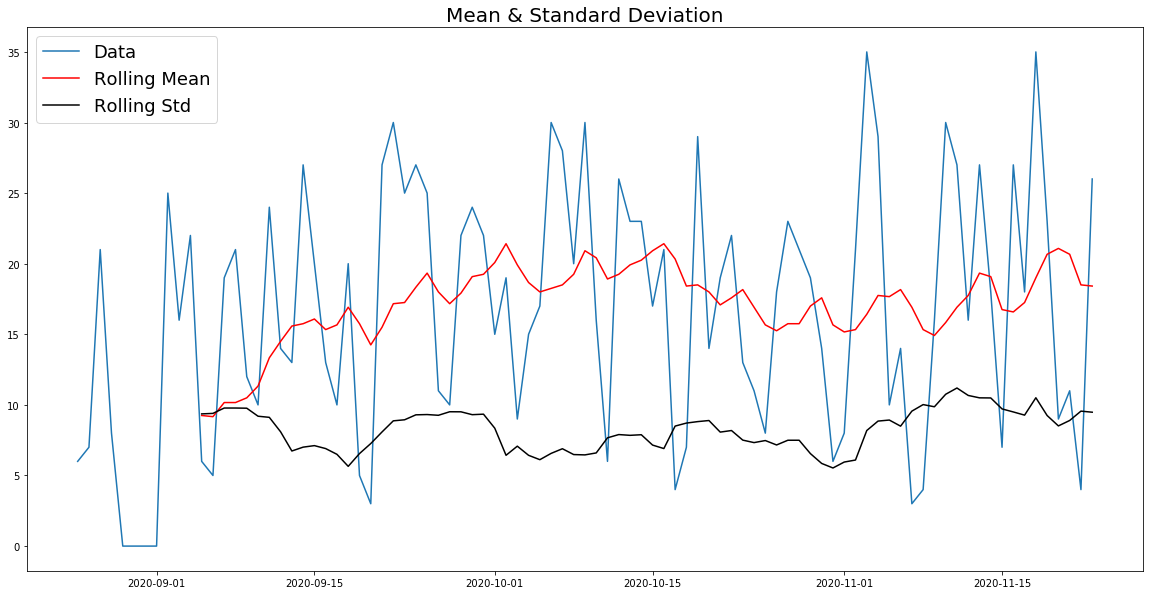

In [12]:
rolling_mean = serie.rolling(window=12).mean()
rolling_std = serie.rolling(window=12).std()

plt.figure(figsize=(20, 10))
plt.plot(serie, label="Data")
plt.plot(rolling_mean, color="red", label="Rolling Mean")
plt.plot(rolling_std, color="black", label="Rolling Std")
plt.legend(loc="best", fontsize=18)
plt.title("Mean & Standard Deviation", size=20)
plt.show()

Podemos asignar pesos a las distintas ventanas de tiempo. Para ello usamos el método **Exponential Weighted Moving Average (EWMA)**. Gráficamente debemos observar que el suavizado es menos pronunciado en retrasos más cercanos.

El suavizado EWMA se puede considerar un **Suavizado Exponencial Simple** (agrega factor suavizado). Veámoslo

In [13]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

# EWMA
ewma_mean = serie.ewm(span=12, adjust=False).mean()
ewma_std = serie.ewm(span=12, adjust=False).std()

# SimpleExpSmoothing
span = 12
alpha = 2/(span + 1)
print("Is EWMA == SimpleExpSmoothing ? \n")
SimpleExpSmoothing(serie).fit(smoothing_level=alpha, optimized=False).fittedvalues.shift(-1) == ewma_mean

Is EWMA == SimpleExpSmoothing ? 



,2020-08-25 00:00:00+00:00,2020-08-26 00:00:00+00:00,2020-08-27 00:00:00+00:00,2020-08-28 00:00:00+00:00,2020-08-29 00:00:00+00:00,2020-08-30 00:00:00+00:00,2020-08-31 00:00:00+00:00,2020-09-01 00:00:00+00:00,2020-09-02 00:00:00+00:00,2020-09-03 00:00:00+00:00,...,2020-11-15 00:00:00+00:00,2020-11-16 00:00:00+00:00,2020-11-17 00:00:00+00:00,2020-11-18 00:00:00+00:00,2020-11-19 00:00:00+00:00,2020-11-20 00:00:00+00:00,2020-11-21 00:00:00+00:00,2020-11-22 00:00:00+00:00,2020-11-23 00:00:00+00:00,count
discovered_date,,,,,,,,,,,,,,,,,,,,,
2020-08-25 00:00:00+00:00,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2020-08-26 00:00:00+00:00,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2020-08-27 00:00:00+00:00,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2020-08-28 00:00:00+00:00,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2020-08-29 00:00:00+00:00,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-19 00:00:00+00:00,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2020-11-20 00:00:00+00:00,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2020-11-21 00:00:00+00:00,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


Si queremos un **Suavizado Exponencial Doble** (agrega factor tendencia) y **Triple/Holt-Winters** (que agrega tendencia y estacionalidad)

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


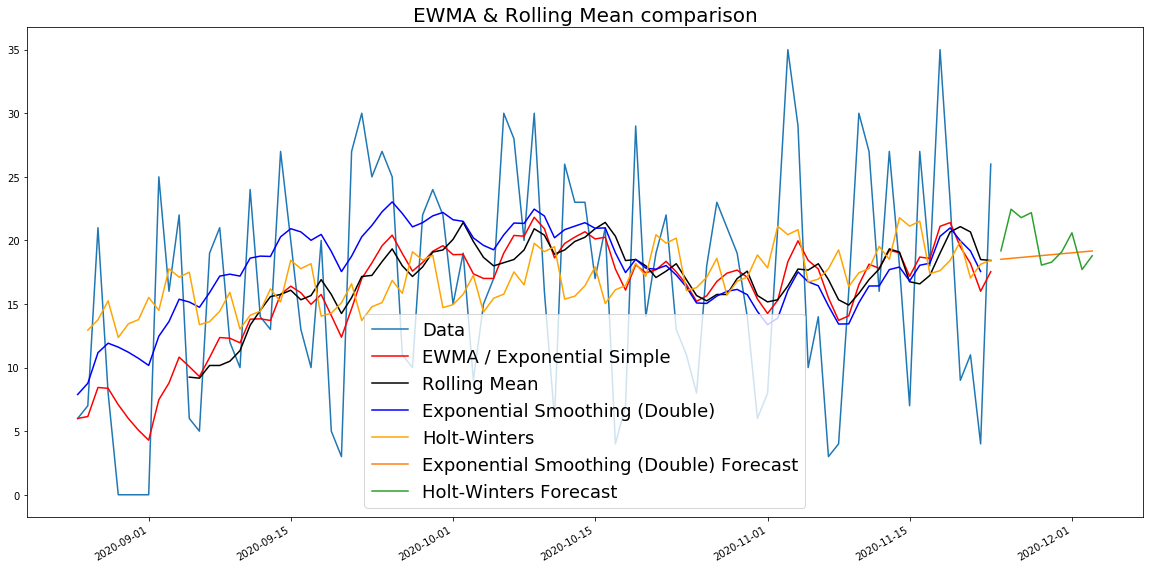

In [14]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# trend="mul" si no hay datos <= 0
model_exp_double = ExponentialSmoothing(serie, trend="add").fit()
exp_double = model_exp_double.fittedvalues.shift(-1)
forecast_double = model_exp_double.forecast(10)

model_exp_triple = ExponentialSmoothing(serie, trend="add", seasonal="add", seasonal_periods=12).fit()
exp_triple = model_exp_triple.fittedvalues.shift()
forecast_triple = model_exp_triple.forecast(10)

plt.figure(figsize=(20, 10))
plt.plot(serie, label="Data")
plt.plot(ewma_mean, color="red", label="EWMA / Exponential Simple")
plt.plot(rolling_mean, color="black", label="Rolling Mean")
plt.plot(exp_double, color="blue", label="Exponential Smoothing (Double)")
plt.plot(exp_triple, color="orange", label="Holt-Winters")

forecast_double.plot(label="Exponential Smoothing (Double) Forecast")
forecast_triple.plot(label="Holt-Winters Forecast")

plt.legend(loc="best", fontsize=16)
plt.title("EWMA & Rolling Mean comparison", size=20)
plt.show()

Tomar el **logaritmo** de la variable dependiente es una forma sencilla de reducir la velocidad a la que aumenta la media móvil.

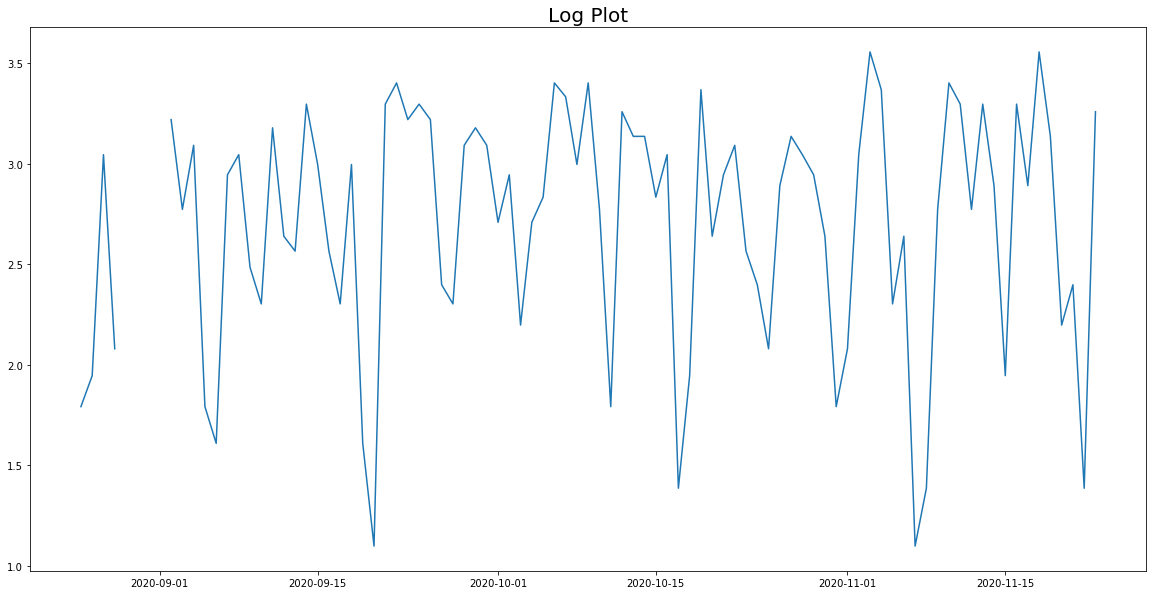

In [15]:
df_log = np.log(serie)
plt.figure(figsize=(20, 10))
plt.plot(df_log)
plt.title("Log Plot", size=20)
plt.show()

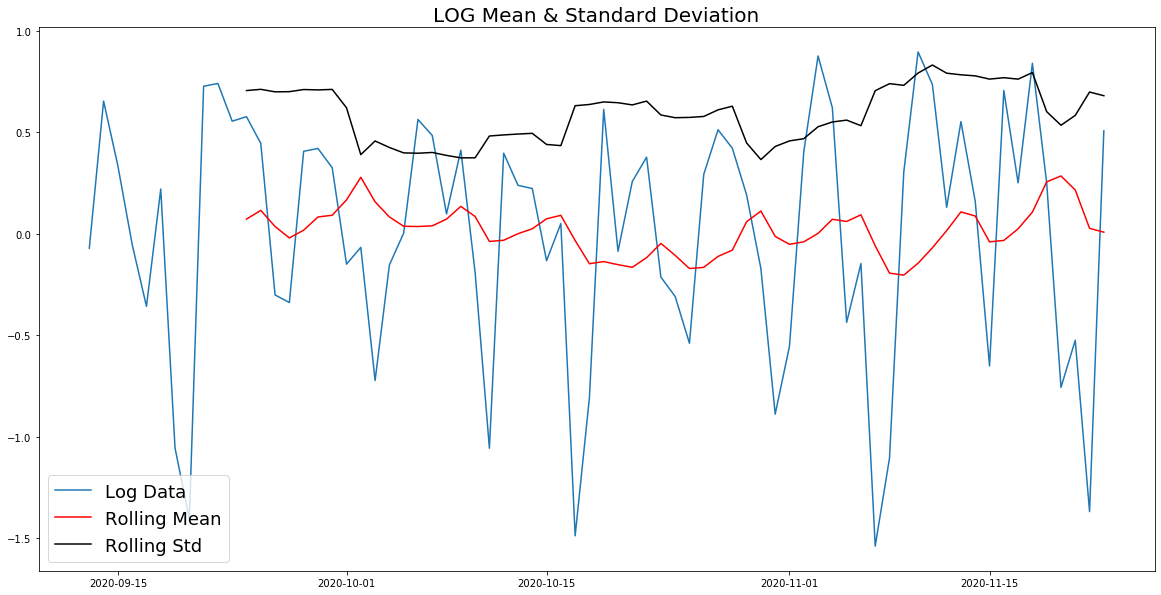

In [16]:
rolling_mean = df_log.rolling(window=12).mean()
df_log_minus_mean = df_log - rolling_mean
df_log_minus_mean.dropna(inplace=True)

rolling_mean = df_log_minus_mean.rolling(window=12).mean()
rolling_std = df_log_minus_mean.rolling(window=12).std()

plt.figure(figsize=(20, 10))
plt.plot(df_log_minus_mean, label="Log Data")
plt.plot(rolling_mean, color="red", label="Rolling Mean")
plt.plot(rolling_std, color="black", label="Rolling Std")
plt.legend(loc="best", fontsize=18)
plt.title("LOG Mean & Standard Deviation", size=20)
plt.show()

Como podemos ver, después de restar la media tenemos que la media móvil y la desviación estándar son aproximadamente horizontales. Por tanto, la serie temporal es estacionaria. Ahora podemos calcular el p-value para esta nueva serie de tiempo que ya es estacionaria.

### Normalización

Podemos normalizar la serie sacando un porcentaje de todos los valores con respecto al primer valor de la serie temporal. Aunque resulta útil para comparar series temporales en distintas escalas, la normalización no implica un cambio de estacionariedad (comprobar con ADF).

## AR, MA, ARMA & ARIMA(p,d,q)

### AutoRegressive Integrated Model Average.

Se trata de un modelo ARMA(p,q) aplicado a una nueva serie temporal generada mediante $d$ integraciones.

$$ \Delta x_t = c + \rho_1 \Delta x_{t-1} + \theta_1 \epsilon_{t-1} + \epsilon_t $$

- **ACF -> Ma(q)**. La correlación entre las observaciones en el momento actual y las observaciones en todos los momentos anteriores. Podemos usar ACF para determinar el número óptimo de términos MA. El número de términos determina el orden del modelo. Las variables del modelo MA serán los errores residuales en los retrasos. Los coeficientes del modelo deben ser menor que 1.


- **PACF -> AR(p)**. Como su nombre indica, PACF es un subconjunto de ACF. PACF expresa la correlación entre las observaciones realizadas en dos puntos en el tiempo descontando los posibles efectos debidos a variables intermedias (no se considera la dependencia creada por los retardos intermedios existentes). Podemos usar PACF para determinar el número óptimo de términos a usar en el modelo AR. El número de términos determina el orden del modelo. Las variables del modelo AR serán los retrasos k. Los coeficientes del modelo deben ser menor que 1.


- **Differenciation -> (d)**. Número de diferencias no estacionales que se debe examinar para establecer la estacionariedad. Número de veces que debemos integrar la serie para asegurar la estacionariedad. Será igual a 0 si la serie temporal es estacionaria.

$\rho_1$ <-> **AR** qué parte de los valores del período anterior es relevante para explicar el actual.

$\theta_1$ <-> **MA** qué parte de los errores del período anterior es relevante para explicar el actual.

$\Delta x_t = x_t - x_{t-1}$ <-> **I** disparidad entre valores en períodos consecutivos.

Por ejemplo, en finanzas, un modelo ARIMA(p,2,q) sobre precios es lo mismo que un modelo ARIMA(p,1,q) sobre diferencias de precios. En esete sentido un modelo ARIMA(p,1,q) sobre un conjunto de datos será lo mismo que un modelo ARIMA(p,0,q) sobre las diferencias consecutivas de las observaciones para dicha variable.

##### Criterios para selección de modelo:

1. Todos los coeficientes significativos.
2. Alto Log-Verosimilitud
3. Bajo criterio de información AIC/BIC
4. Es aconsejable empezar por parámetros más altos en modelos ARMA e ir decendiendo. Para modelos ARIMA podemos empezar por el más bajo e ir subiendo.

##### Problemas:

1. Cuantas más capaz de integración, más costoso computacionalmente será nuestro modelo.
2. Al calcular diferencias entre observaciones podríamos hacer que nuestras nuevas observaciones sean cada vez menos significativas
3. Debido a (2) puede ocurrir que los modelos no converjan.
4. Además podemos encontrar inestabilidad numérica. Dependiendo del cero de la máquina podemos perder información.
5. Cuantos más parámetros, más complejo es nuestro modelo y más difícil será interpretarlo. En particular, interpretar el parámentro `d=3` consiste en identificar la pendiente de la pendiente de la pendiente de la observación.

### Comparación de modelos

A la hora de comparar modelos es importante analizar si el retraso $k$ es significativo. Para ello podemos consultar `model.summary()` y analizar el p-value `P>|z|` para el último retraso. Si este valor es menor que 0.05 (nivel de significación) entonces rechazaríamos la hipótesis nula de que el retraso $k$ es significativamente igual a cero. En resumen

- $P>|z| < 0.05$ (probabilidad de H0) -> retraso $k$ significativo..

In [17]:
def LLR_test(mod_1, mod_2, DF=1):
    """ 
    Compare models by Log-Likelihood Ratio Test
    
    mos_1, mod_2: models to compare where mod_2 is more complex than mod_1
    DF: dregrees of freedom between mod_1 and mod_2
    
    Null Hypothesis: mod_1 and mod_2 are are significantly the same.
    A p-value lower than 0.05 implies we reject the null hypothesis. So adding more complexity to the model is better.
    
    It is necessary that the coefficient related to the last lags of mod_2 become disctinct to 0. Print with mod_2.summary()
    """
    L1 = mod_1.llf
    L2 = mod_2,llf
    LR = 2 * (L2 - L1)
    return chi2.sf(LR, DF).round(3) # p-value for this test

La prueba **Log-Likelihood Ratio Test** de un modelo ARMA debe haserce con respecto a su correspondiente AR y MA por separado.

#### Modelos anidados

La prueba LLR **solo** es aplicable a modelos anidados. Dados dos modelos ARMA $(p_1, q_1)$ y $(p_2, q_2)$ se dice que el segundo modelo se encuentra anidado al primero si cumple las siguientes condiciones

1. $p_1 + q_1 > p_2 + q_1 $
2. $p_1 \geq p_2$
3. $q_1 \geq p_2$

Sin embargo podemos comparar modelos no anidados mediante el LL (método `.llf`, cuanto más alto mejor es el modelo) y el AIC/BIC (métodos `.aic` y `.bic` mejor cuanto más bajo sea el valor).

$$ AIC = -2 \frac{Ln (L)}{T} + 2 \frac{2k}{T} $$

$$ BIC = -2 \frac{Ln (L)}{T} + 2 \frac{Ln (T)}{T} $$

Donde $k$ es el número de parámetros, $Ln (L)$ es Log-versosimilitud y $T$ la longitud de la serie de tiempo.

Por otro, lado, comparando ACF/PACF sobre los residuos del modelo podemos identificar observaciones que pueden ser significativas (aquellas que salen del área azul), lo que nos llevaría a identificar posibles candidatos de parámetros $p, q$ que incluyan esas observaciones en un nuevo modelo.

Para calcular ACF/PACF de los residuos del modelo hay que tener en cuenta que AR**I**MA trabaja sobre diferencias dadas por el parámetro $d$. Si $d$ es igual a 1 se nos borrará el primer valor de la serie ocasionando que la autocorrelación se rompa. Para solucionarlo tenemos que calcular la autocorrelación a partir del elemento número $d$.

ARIMA(0, 0, 0) - AIC:650.6115095566669 - LL:-323.30575477833344
ARIMA(0, 0, 1) - AIC:633.8721053649598 - LL:-313.9360526824799
ARIMA(0, 0, 2) - AIC:628.7565922559143 - LL:-310.3782961279571
ARIMA(0, 0, 3) - AIC:623.90969771218 - LL:-306.95484885609
ARIMA(0, 0, 4) - AIC:613.4743250463385 - LL:-300.7371625231693
ARIMA(0, 0, 5) - AIC:598.3338127598562 - LL:-292.1669063799281
ARIMA(0, 0, 6) - AIC:587.4652570711283 - LL:-285.7326285355642
ARIMA(0, 1, 0) - AIC:671.2529560126687 - LL:-334.62647800633437
ARIMA(0, 1, 1) - AIC:638.2291498964797 - LL:-317.11457494823986
ARIMA(0, 1, 2) - AIC:623.4332095335801 - LL:-308.71660476679006
ARIMA(0, 1, 3) - AIC:618.6897766788118 - LL:-305.3448883394059
ARIMA(0, 1, 4) - AIC:614.6315505377106 - LL:-302.3157752688553
ARIMA(0, 1, 5) - AIC:600.3786920295191 - LL:-294.18934601475956
ARIMA(0, 1, 6) - AIC:582.4233157336769 - LL:-284.21165786683844
ARIMA(1, 0, 0) - AIC:643.5076057146 - LL:-318.7538028573
ARIMA(1, 0, 1) - AIC:634.2162144296167 - LL:-313.1081072148

/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 0, 3) - AIC:603.0624354613083 - LL:-293.53121773065413
ARIMA(3, 0, 4) - AIC:598.0310818340303 - LL:-290.01554091701513


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 0, 5) - AIC:592.690927902147 - LL:-286.3454639510735


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 0, 6) - AIC:580.8044138170712 - LL:-279.4022069085356
ARIMA(3, 1, 0) - AIC:647.1293427792763 - LL:-319.56467138963814
ARIMA(3, 1, 1) - AIC:627.4320642609217 - LL:-308.71603213046086
ARIMA(3, 1, 2) - AIC:626.5795717818384 - LL:-307.2897858909192
ARIMA(3, 1, 3) - AIC:615.5086786136619 - LL:-300.75433930683096
ARIMA(3, 1, 4) - AIC:605.7121461040134 - LL:-294.8560730520067
ARIMA(3, 1, 5) - AIC:591.7538227978384 - LL:-286.8769113989192
ARIMA(3, 1, 6) - AIC:580.6758453563593 - LL:-280.33792267817967
ARIMA(4, 0, 0) - AIC:622.1343866413281 - LL:-305.06719332066405
ARIMA(4, 0, 1) - AIC:611.9139254711165 - LL:-298.95696273555825
ARIMA(4, 0, 2) - AIC:609.3960923280894 - LL:-296.6980461640447


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(4, 0, 3) - AIC:604.8471187683213 - LL:-293.4235593841606


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(4, 0, 4) - AIC:600.0747670922244 - LL:-290.0373835461122


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(4, 0, 5) - AIC:593.7488887493923 - LL:-285.87444437469617


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(4, 0, 6) - AIC:590.3802755713963 - LL:-283.19013778569814
ARIMA(4, 1, 0) - AIC:632.0356690571991 - LL:-311.01783452859956
ARIMA(4, 1, 1) - AIC:611.6670208641493 - LL:-299.83351043207466
ARIMA(4, 1, 2) - AIC:610.2641465535609 - LL:-298.13207327678043


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(4, 1, 3) - AIC:597.9702554872487 - LL:-290.98512774362433


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(4, 1, 4) - AIC:588.3738062979668 - LL:-285.1869031489834


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(4, 1, 5) - AIC:584.6458624043499 - LL:-282.32293120217497


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(4, 1, 6) - AIC:579.3765975005563 - LL:-278.68829875027814
ARIMA(5, 0, 0) - AIC:614.1911558815187 - LL:-300.09557794075937
ARIMA(5, 0, 1) - AIC:598.9301182238471 - LL:-291.46505911192355
ARIMA(5, 0, 2) - AIC:604.261033274789 - LL:-293.1305166373945


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(5, 0, 3) - AIC:603.8479297540777 - LL:-291.9239648770388


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(5, 0, 4) - AIC:588.135514892444 - LL:-283.067757446222


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(5, 0, 5) - AIC:586.146516478579 - LL:-281.0732582392895
ARIMA(5, 0, 6) - AIC:589.7686286825052 - LL:-281.8843143412526
ARIMA(5, 1, 0) - AIC:613.9783386952412 - LL:-300.9891693476206
ARIMA(5, 1, 1) - AIC:601.9568373271193 - LL:-293.97841866355964
ARIMA(5, 1, 2) - AIC:606.2365905420952 - LL:-295.1182952710476
ARIMA(5, 1, 3) - AIC:589.9265301822028 - LL:-285.9632650911014


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(5, 1, 4) - AIC:590.1926248622918 - LL:-285.0963124311459
ARIMA(5, 1, 5) - AIC:583.6630099663575 - LL:-280.8315049831788


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(5, 1, 6) - AIC:568.9579302126106 - LL:-272.4789651063053
ARIMA(6, 0, 0) - AIC:602.3623084599755 - LL:-293.1811542299877
ARIMA(6, 0, 1) - AIC:590.8008986395955 - LL:-286.40044931979776


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(6, 0, 2) - AIC:591.0522401548802 - LL:-285.5261200774401


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(6, 0, 3) - AIC:604.1690525418331 - LL:-291.08452627091657


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(6, 0, 4) - AIC:585.4493270288287 - LL:-280.7246635144144


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(6, 0, 5) - AIC:584.363341858099 - LL:-279.1816709290495


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(6, 0, 6) - AIC:579.4259946859206 - LL:-275.7129973429603
ARIMA(6, 1, 0) - AIC:582.2751432012133 - LL:-284.13757160060663
ARIMA(6, 1, 1) - AIC:584.0294179956859 - LL:-284.01470899784294


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(6, 1, 2) - AIC:586.192434042995 - LL:-284.0962170214975
ARIMA(6, 1, 3) - AIC:586.7884944259413 - LL:-283.39424721297064
ARIMA(6, 1, 4) - AIC:581.8627600494689 - LL:-279.93138002473444
ARIMA(6, 1, 5) - AIC:581.866116641771 - LL:-278.9330583208855


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(6, 1, 6) - AIC:573.8486910944509 - LL:-273.92434554722547
Parameters with lower AIC:  (5, 1, 6)
P-values: 
 ar.L1     9.013498e-01
ar.L2     1.536987e-22
ar.L3     3.291921e-03
ar.L4     2.673551e-05
ar.L5     1.607422e-16
ma.L1     7.212667e-01
ma.L2     8.456886e-01
ma.L3     9.838361e-01
ma.L4     8.241978e-01
ma.L5     7.780478e-01
ma.L6     8.361923e-01
sigma2    8.360193e-01
dtype: float64


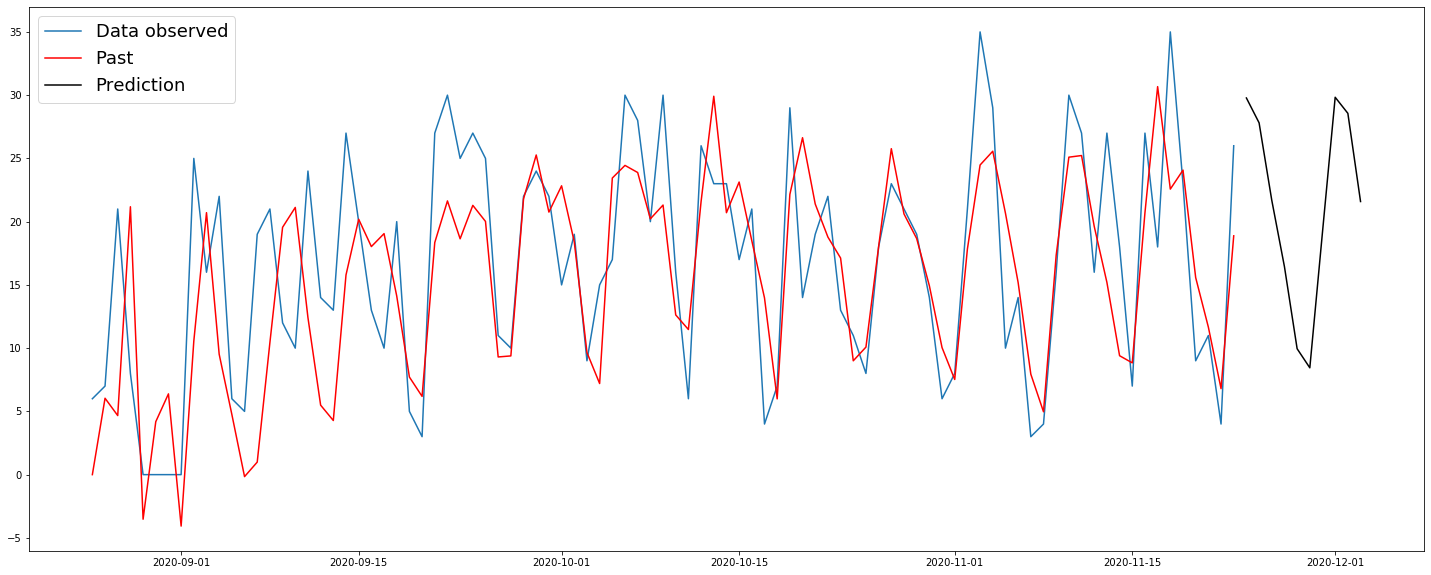

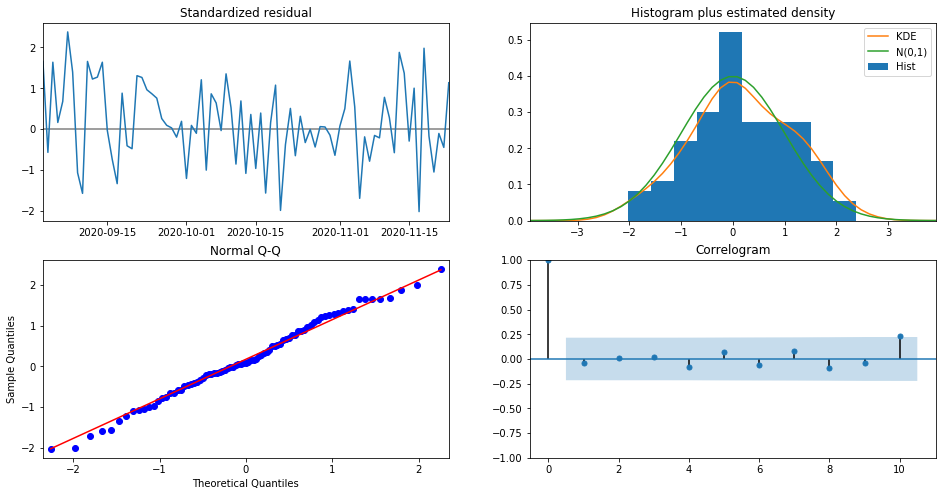

Predictions: 
 2020-11-24 00:00:00+00:00    29.776376
2020-11-25 00:00:00+00:00    27.812961
2020-11-26 00:00:00+00:00    21.691325
2020-11-27 00:00:00+00:00    16.438331
2020-11-28 00:00:00+00:00     9.952059
2020-11-29 00:00:00+00:00     8.444615
2020-11-30 00:00:00+00:00    19.179613
2020-12-01 00:00:00+00:00    29.833246
2020-12-02 00:00:00+00:00    28.562871
2020-12-03 00:00:00+00:00    21.590763
Freq: D, dtype: float64


In [18]:
import itertools
from statsmodels.tsa.arima.model import ARIMA

p = q = range(0, 7)
d = range(0, 2)
pdq = list(itertools.product(p, d, q))
my_models = {}
best_aic = float("inf")
for param in pdq:
    try:
        model = ARIMA(serie, order=param, enforce_stationarity=False, enforce_invertibility=False)
        results = model.fit()
        # Mejor modelo con bajo AIC y alto LL
        print("ARIMA{} - AIC:{} - LL:{}".format(param, results.aic, results.llf))
        my_models[param] = results.aic
    except:
        continue
    if results.aic < best_aic: # Akaike information criteria
        best_model = results
        best_aic = results.aic
        best_param = param

print("Parameters with lower AIC: ", best_param)

past = best_model.predict(start=serie.index[0])
forecast = best_model.forecast(steps=10)

print("P-values: \n", best_model.pvalues)

plt.figure(figsize=(25, 10))
plt.plot(serie, label="Data observed")
plt.plot(past, color="red", label="Past")
plt.plot(forecast, color="black", label="Prediction")
plt.legend(loc="upper left", fontsize=18)
best_model.plot_diagnostics(figsize=(16, 8)) # Fiabilidad del modelo
plt.show()
print("Predictions: \n", forecast)

ADF test over model residuals: 
ADF:  -10.089765951368774
p-value:  1.1302624276528122e-17
Lags used:  0
Oservations number:  90
Critical values:  {'1%': -3.505190196159122, '5%': -2.894232085048011, '10%': -2.5842101234567902}


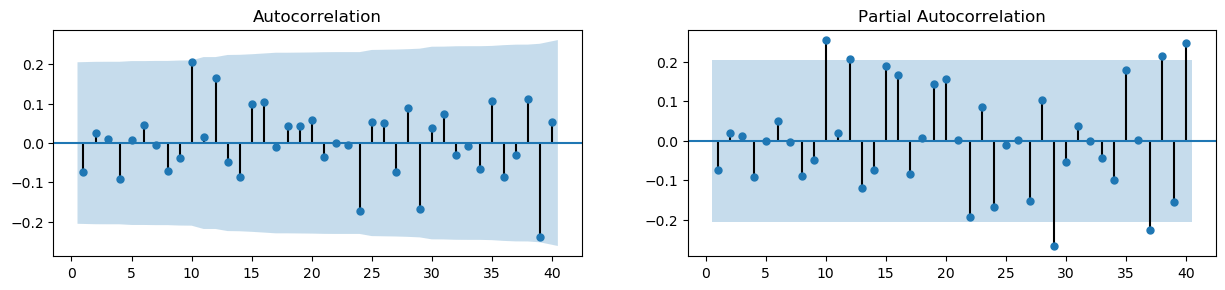

In [19]:
print("ADF test over model residuals: ")
# p-value < 0.05 rechaza la hipótesis nula -> residuos estacionarios
adf, p_value, usedlag, n_obs, critical_values, *values = adfuller(best_model.resid)

print ("ADF: ", adf)
print ("p-value: ", p_value)
print ("Lags used: ", usedlag)
print ("Oservations number: ", n_obs)
print ("Critical values: ", critical_values)

fig, ax = plt.subplots(1, 2, figsize=(15, 3), dpi=100)
plot_acf(best_model.resid, lags=40, zero=False, use_vlines=True, ax=ax[0])
plot_pacf(best_model.resid, lags=40, zero=False, use_vlines=True, ax=ax[1], method=("ols"))
fig.show()

Si en nuestro modelo ARIMA hemos aplicado uno o más órdenes de diferenciación para convertir la serie en estacionaria tenemos que tener en cuenta que para hacer predicciones sobre nuestra serie original debemos transformar nuestra serie predicción a la escala original.

In [20]:
#df_forecast = serie.iloc[-1] + forecast.cumsum()

### AUTO ARIMA

Método para seleccionar modelos automáticamente. Se basa en criterio LL y AIC/BIC

- Pros
    - Ahorra tiempo.
    - No es necesario comprender la estadística detrás del modelo.
    - Elimina ambiguedades.
    - Reduce el riesgo de error humano.
- Contras
    - Se confía ciegamente en el criterio del método.
    - El resultado no muestra una comparativa de los modelos.
    - La definición del mejor modelo requiere experiencia en el tema de estudio. Por ejemplo al tratar la complejidad del modelo elegido.
    - Toma unos variables por defecto que nos pueden llevar a malinterpretar los resultados.

In [21]:
#!pip install pmdarima

In [22]:
"""
from pmdarima.arima import auto_arima

model = auto_arima(serie, exogenous=None, m=5, max_order=None,
                   max_p=7, max_q=7, max_d=2, max_P=4, max_Q=4, max_D=2,
                   max_iter=50, alpha=0.5, n_jobs=-1, trend="ct", information_criterion="oob",
                   out_of_simple_size=int(len(serie) * 0.2))

# exogenous -> outside factors
# m -> seasonal cycle length
# max_order ->maximum amount of variables to be used in the regression (p + q)
# alpha -> level of significance, default 5%
# n_jobs -> how many models to fit at the same time (-1 indicates "as many as possible")
# trend -> ct usually
# information_criterion -> "aic"=akaike, "aicc"=corrected_aic, "bic"=bayesian, "hqic"=hannan-quinn, "oob"=out_of_bag
# out_of_sample_size -> validates the model selection (pass the entire dataset and set 20% to be the out_of_sample_size)

model = auto_arima(serie,)
model # Para ver los parámetros ajustados
model.summary() # Aunque el modelo ponga SARIMAX hay que evaluar los parámetros
#predictions = pd.DataFrame(model.predict(n_periods=len(serie[start_date:end_date])), index=serie[start_date:end_date].index)
"""

'\nfrom pmdarima.arima import auto_arima\n\nmodel = auto_arima(serie, exogenous=None, m=5, max_order=None,\n                   max_p=7, max_q=7, max_d=2, max_P=4, max_Q=4, max_D=2,\n                   max_iter=50, alpha=0.5, n_jobs=-1, trend="ct", information_criterion="oob",\n                   out_of_simple_size=int(len(serie) * 0.2))\n\n# exogenous -> outside factors\n# m -> seasonal cycle length\n# max_order ->maximum amount of variables to be used in the regression (p + q)\n# alpha -> level of significance, default 5%\n# n_jobs -> how many models to fit at the same time (-1 indicates "as many as possible")\n# trend -> ct usually\n# information_criterion -> "aic"=akaike, "aicc"=corrected_aic, "bic"=bayesian, "hqic"=hannan-quinn, "oob"=out_of_bag\n# out_of_sample_size -> validates the model selection (pass the entire dataset and set 20% to be the out_of_sample_size)\n\nmodel = auto_arima(serie,)\nmodel # Para ver los parámetros ajustados\nmodel.summary() # Aunque el modelo ponga SAR

### Prophet Facebook library

Esta librería fue diseñada específicamente para pronosticar conjuntos de datos comerciales que son muy comunes en Facebook, específicamente conjuntos de datos con frecuencia muy alta de tiempo (diaria, horas, minutos) donde al final tendríamos conjuntos de datos muy grandes.

En esencia el procedimiento por detrás va a ser un modelo de regresión adictiva con cuatro componentes principales que son:

- Primero una tendencia de crecimiento por partes lineal o logística. El método detecta automáticamente los cambios de tendencias seleccionando los puntos de cambio en los datos.
- Un modelo de componentes estacional anual modelado a través de una serie de Fourier.
- Un componente estacional semanal que utiliza variables dummy.
- Opcionalmente se puede también considerar una lista proporcionada por el usuario de días festivos importantes, es decir que admite una lista de información exógena sobre próximas fechas vacacionales que también se quiere modelar.

In [23]:
#!pip install fbprophet

Importing plotly failed. Interactive plots will not work.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


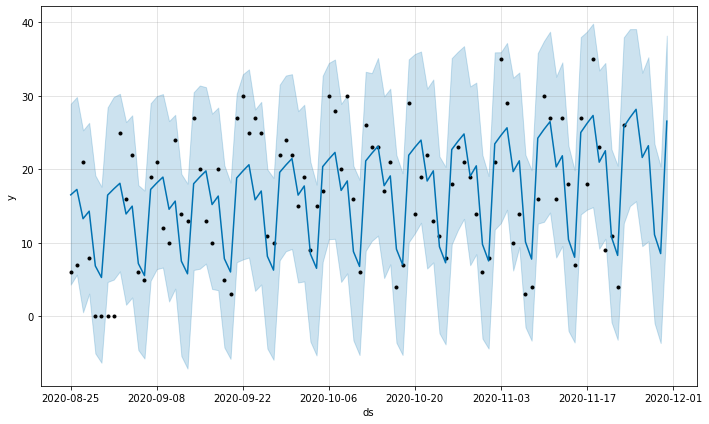

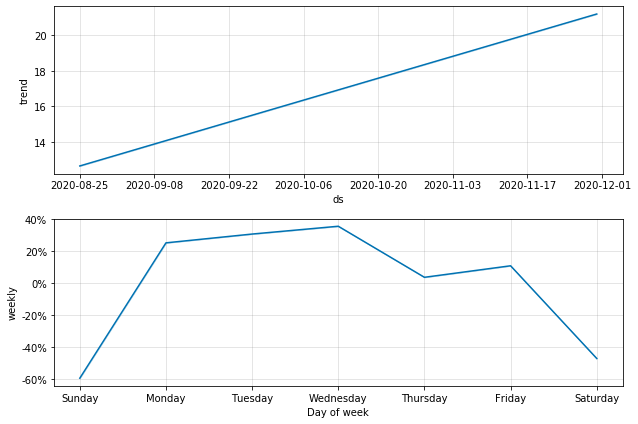

In [24]:
from fbprophet import Prophet

df = serie.copy(deep=True)

df.reset_index(inplace=True)
df.columns = ["ds", "y"] # Formato de la librería. Obligatorio
df["ds"] = pd.to_datetime(df["ds"]).dt.tz_localize(None)

m = Prophet(growth="linear", seasonality_mode="multiplicative", interval_width=0.95)
m.fit(df)

future = m.make_future_dataframe(periods=7, freq="D", include_history=True)
forecast = m.predict(future)
forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]].tail(2) # predicciones en yhat

m.plot(forecast)
m.plot_components(forecast)
#plt.xlim("fecha1", "fecha")
plt.show()

## ARMAX & ARIMAX(p,d,q)

Son modelos ARMA/ARIMA que incluyen un factor originado por factores externos, es decir, otros datos que deseamos incluir en el modelo y que creamos que afecten en nuestra predicción: nuevos datos, otras variables (incluso categóricas), valores booleanos, combinación de varios factores diferentes (matrices)

$$ x_t = c + \beta Y + \rho_1 x_{t-1} + \theta_1 \epsilon_{t-1} + \epsilon_t $$

$$ \Delta x_t = c + \beta Y + \rho_1 \Delta x_{t-1} + \theta_1 \epsilon_{t-1} + \epsilon_t $$

El coeficiente $\beta$ es optimizado por el modelo mientras que $Y$ serán las variables exógenas de nuestro modelo.

In [25]:
#model = ARIMA(serie, exog=new_variable, order=param)
#model.fit().summary()

## SAR, SMA, SARMA, SARIMA & SARIMAX(p,d,q)(P,D,Q,s)

Modelos que incluyen una componenete estacional. Los parámetros $P,D,Q$ son variaciones estacionales de $p,d,q$ mientras que $s$ indica la estacionalidad, es decir, la cantidad de períodos que tienen que pasar para que la tendencia reaparezca. Si $s = 1$ entonces no tendríamos estacionalidad y nos encomtramos ante los modelos típicos sin estacionalidad.

El número de coeficientes a estimar será de $p + q + P + Q$

**Ejemplo** $(1,0,2)(2,0,1,5)$

$$ x_t = c + \rho_1 x_{t-1} + \theta_1 \epsilon_{t-1} + \theta_2 \epsilon_{t-2} + \Phi_1 (x_{t-5} + \rho_1 x_{t-6}) + \Phi_2 (x_{t-10} + \rho_1 x_{t-11}) + \Theta_1 (\epsilon_{t-5} + \theta_1 \epsilon_{t-6} + \theta_2 \epsilon_{t-7}) + \epsilon_t $$

In [26]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(serie, exog=None, order=(1,1,1), seasonal_order=(2,0,1,5))
model.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             count   No. Observations:                   91
Model:             SARIMAX(1, 1, 1)x(2, 0, 1, 5)   Log Likelihood                -319.273
Date:                           Mon, 23 Nov 2020   AIC                            650.546
Time:                                   16:46:39   BIC                            665.545
Sample:                               08-25-2020   HQIC                           656.595
                                    - 11-23-2020                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2476      0.172      1.443      0.149      -0.089       0.584
ma.L1         -0.9288      0.069    -13.526      0.000      -1.063      -0.794
ar.S.L5       -0.9374      0.246     -3.816      0.000      -1.419      -0.456
ar.S.L10      -0.2153      0.138     -1.563      0.118      -0.485       0.055
ma.S.L5        0.8302      0.265      3.133      0.002       0.311       1.350
sigma2        68.5656     12.957      5.292      0.000      43.170      93.961
===================================================================================
Ljung-Box (Q):                      126.75   Jarque-Bera (JB):                 3.11
Prob(Q):                              0.00   Prob(JB):                         0.21
Heteroskedasticity (H):               0.98   Skew:                             0.24
Prob(H) (two-sided):                  0.95   Kurtosis:                         2.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## ARCH(q)

### AutoRegressive Conditional Heteroscedasticity

Modelo basado en volatilidad. El modelo consiste en varias ecuaciones, donde una corresponde a la media (serie de tiempo modelable por un ARIMAX) y otra para la varianza. ¿Por qué dos ecuaciones? Para medir cambios inesperados debemos tener algún tipo de norma, establecida por la primera ecuación, que establece un modelo de base a partir del cual mediremos si nos estamos alejando mucho de él o no.

##### Heterocedasticidad

"Modelo con dispersión diferente". Las medidas de dispersión que conocemos son la varianza y la desviación típica. Al estar relacionadas nos quedaremos con la varianza

##### Condicional

"Un valor depende de otro". Se basa en la probabilidad condicionada $P(A|B)$.

El resultado es que en un modelo ARCH tenemos que la varianza va a depender de otros valores. Estos valores serán los errores (al cuadrado) de observaciones pasadas (modelo autoregresivo). Por lo tanto tendremos que un modelo ARCH(q) seguirá la siguiente ecuación

$$x_t = \mu_t + \epsilon_t$$

$$\mu_t = c_0 + \rho_1 \mu_{t-1}$$

$$Var(x_t | x_{t-1}) = \sigma_t^2 = \alpha_0 + \alpha_1 \epsilon_{t-1}^2 + ... + \alpha_q \epsilon_{t-q}^2$$

Se usará la PACF para la selección del parámetro $q$.

Lo realmente importante es hacer un estudio de la magnitud de los residuos. Como no nos interesa el signo de los residuos cogeremos su valor al cuadrado $\epsilon^2_t$. Esto penaliza más las diferencias más altas entre valores y predicciones.

- Menor varianza -> Menos volatilidad

Finalmente, el modelo no se utiliza para predecir valores futuros sino para medir variaciones futuras (la estabilidad de futuras observaciones), es decir, si las observaciones son estables en el tiempo.

In [27]:
#!pip install arch

In [28]:
from arch import arch_model

model = arch_model(serie, mean="Constant", vol="ARCH", p=1) # ARCH(1)
result = model.fit(update_freq=5) # para mostrar datos de 5 en 5
result.summary()

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 326.4248557855802
            Iterations: 4
            Function evaluations: 22
            Gradient evaluations: 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:                  count   R-squared:                      -0.001
Mean Model:             Constant Mean   Adj. R-squared:                 -0.001
Vol Model:                       ARCH   Log-Likelihood:               -326.425
Distribution:                  Normal   AIC:                           658.850
Method:            Maximum Likelihood   BIC:                           666.382
                                        No. Observations:                   91
Date:                Mon, Nov 23 2020   Df Residuals:                       88
Time:                        16:46:40   Df Model:                            3
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            16.8707      0.973     17.342  2.253e-67 [ 14.964, 18.777]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega         65.9798     10.127      6.515  7.261e-11    [ 46.131, 85.829]
alpha[1]       0.1449  7.829e-02      1.851  6.423e-02 [-8.565e-03,  0.298]
===========================================================================

Covariance estimator: robust
"""

## GARCH (p,q)

### Generalized AutoRegressive Conditional Heteroscedasticity

Este modelo extiende el modelo ARCH al agregar términos basados en varianzas condicionadas de observaciones pasadas. Se basa en la idea de que períodos de alta volatilidad (varianza) son seguidos por períodos de alta volatilidad (y viceversa), por lo que tiene sentido incluir términos que incluyan esta información para hacer estimaciones del futuro.

$$Var(x_t | x_{t-1}) = \sigma_t^2 = \Omega + \alpha_1 \epsilon_{t-1}^2 + ... + \alpha_q \epsilon_{t-q}^2 + \beta_1 \sigma_{t-1}^2$$

$$ \sigma_{t-1}^2 = \alpha_0 + \alpha_1 \epsilon_{t-2}^2 $$

Se tiene que GARCH(1,0) = ARCH(1). Además, en finanzas (variable retorno de precios) ocurre que ningún modelo ARCH de orden superior supera al GARCH(1,1). Esto ocurre por la redundancia de términos $\epsilon_{t-k}^2$ ya incluidos en $\sigma_{t-k-1}^2$

GARCH es un modelo ARMA cuadrado para los términos de error de la ecuación de la media. Ambos modelos comparten la misma forma funcional. Existen modelos ARMA-GARCH donde ARMA modela la media y GARCH la varianza.

In [29]:
from arch import arch_model

start_date = serie[-9:].index[0]
model = arch_model(serie, mean="Constant", vol="GARCH", p=1, q=1, dist="Normal") # GARCH(1,1)
result = model.fit(last_obs=start_date, update_freq=5) # para mostrar datos de 5 en 5
result.summary()

forecast = result.forecast(horizon=10, align="target")
forecast.residual_variance[start_date:]#.plot(figsize=(20, 5), color="red", zorder=2)
#plt.show()

Iteration:      5,   Func. Count:     34,   Neg. LLF: 291.94632505775644
Iteration:     10,   Func. Count:     64,   Neg. LLF: 291.9327290275444
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 291.92476989262036
            Iterations: 13
            Function evaluations: 83
            Gradient evaluations: 13


,h.01,h.02,h.03,h.04,h.05,h.06,h.07,h.08,h.09,h.10
discovered_date,,,,,,,,,,
2020-11-15 00:00:00+00:00,60.972453,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-11-16 00:00:00+00:00,72.132749,65.606344,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-11-17 00:00:00+00:00,77.971044,72.448524,68.447301,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-11-18 00:00:00+00:00,62.225882,76.027880,72.642120,70.189041,NaN,NaN,NaN,NaN,NaN,NaN
2020-11-19 00:00:00+00:00,114.405556,66.374799,74.836560,72.760811,71.256871,NaN,NaN,NaN,NaN,NaN
2020-11-20 00:00:00+00:00,84.556284,98.365235,68.918427,74.106183,72.833578,71.911539,NaN,NaN,NaN,NaN
2020-11-21 00:00:00+00:00,75.966247,80.065174,88.531198,70.477880,73.658402,72.878190,72.312904,NaN,NaN,NaN
2020-11-22 00:00:00+00:00,67.306319,74.798774,77.311754,82.502123,71.433953,73.383875,72.905541,72.558974,NaN,NaN
2020-11-23 00:00:00+00:00,87.145860,69.489525,74.083017,75.623681,78.805804,72.020105,73.215567,72.922309,72.709835,NaN
